### Seasonal sea ice extent and nutrient availability in the Siberian Sea
* Do recent reductions in sea ice extent lead to decreased nutrient availabilty?
* Do models capture the extent and seasonality of sea ice extent? 

### Methods
* Observations: Daily sea ice concentration ranging from 2002 to 2019 obtained from AMSR2 and AMSR-E satellite products 
* Model data: Sea ice and sea surface nitrate concentration from CNRM and UKESM historical runs ranging from 1850 to 2014


### Abstract

### Introduction

### Results 

In [2]:
# Load useful packages
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy
from datetime import datetime, timedelta
import numpy as np
import pyproj
from dask.diagnostics import ProgressBar
import matplotlib.dates as mdate
import intake
import cftime

### Satellite data

In [40]:
# Import all satellite observations
sat = xr.open_mfdataset("SICdata/AMSR*.nc", combine='by_coords')

In [41]:
# Convert co-ordinates in satellite data from x and y to latitude and longitude
# We want the output coordinates in WGS 84 longitude and latitude
projOut = pyproj.Proj(init='epsg:4326')
# The input coordinates are in meters on a North Polar Stereographic grid 
projIn = pyproj.Proj(init='epsg:3411', preserve_units=True)
xx, yy = np.meshgrid( sat.x.values, sat.y.values)
lon,lat= pyproj.transform(projIn, projOut, xx, yy )
sat['lon'] = (('y','x'),lon)
sat['lat'] = (('y','x'),lat)

/srv/conda/envs/notebook/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/srv/conda/envs/notebook/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_343/1579399248.py:7: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon,lat= pyproj.tra

In [42]:
# Select area of interest: Siberian Sea
sat_SS = sat.where((sat.lon>= 100) & (sat.lon<= 160) & (sat.lat<= 80) & (sat.lat>= 70), drop = True) 

In [43]:
# Compute the sea ice extent (km^2) from sea ice concentration for the Siberian Sea
area = 6.25**2 # The satellite data grid cell sizes are the same (resolution of 6.25 km^2)
# We count the grid cells which have a sea ice concentration >15% and multiply by the area
with ProgressBar():
    iceExt = ((xr.where(sat_SS.z>15, 1.,0).sum(dim=['x','y']))*area).compute()
iceExt=xr.where(iceExt>0,iceExt,np.NaN)

[########################################] | 100% Completed | 193.31 s


In [7]:
ys = np.unique(sat_SS.time.dt.year) #x axis = years
doy= np.arange(150,330) #y axis = day of years 
t2d = np.array([
    [np.datetime64(str(y)) + np.timedelta64(d, 'D') for d in doy ] 
        for y in ys])

In [8]:
ice2d = np.array([
        [ iceExt.sel(time=d) if d in iceExt.time else np.NaN for d in y ]
            for y in t2d ])

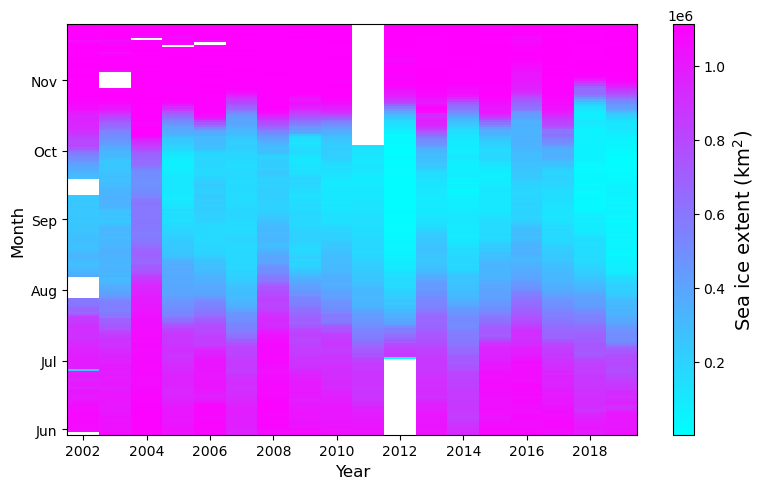

In [11]:
#Plot figure
fig, ax = plt.subplots(figsize = (8,5))
pl=ax.pcolormesh(ys, 
            [np.datetime64('2000') + np.timedelta64(d, 'D') for d in doy], 
               ice2d.T,
                cmap=plt.colormaps['cool'])
cbar = fig.colorbar(pl)
cbar.set_label(r'Sea ice extent (km$^{2}$)', size = 14)
fmt = mdate.DateFormatter('%b')
ax.yaxis.set_major_formatter(fmt)
ax.yaxis.set_major_locator(mdate.MonthLocator())
ax.set_ylabel('Month', size = 12)
ax.set_xlabel('Year', size = 12)
fig.tight_layout()
plt.savefig('Heatmap SS.png')

 Figure 1: Heat map indicating the timing of sea ice melt and reformation over 18 years from 2002 to 2019.<br>The color bar (blue to purple) shows sea ice extent.

### CMIP 6 model data

In [3]:
# To include model data for comparison open cmip6 online catalogue
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)

In [6]:
# We are interested in historical data from CNRM and UKESM with variables: siconc, no3 and areacello
cat = col.search(source_id=['CNRM-ESM2-1','UKESM1-0-LL'], 
                 experiment_id=['historical','piControl'], table_id=['SImon','Omon','Ofx'], 
                 variable_id=['siconc','no3','areacello']) 
                 #member_id=['r1i1p1f1'])

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,CNRM-CERFACS,CNRM-ESM2-1,piControl,r1i1p1f2,Omon,no3,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20181115
1,CMIP,CNRM-CERFACS,CNRM-ESM2-1,piControl,r1i1p1f2,SImon,siconc,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20181115
2,CMIP,CNRM-CERFACS,CNRM-ESM2-1,piControl,r1i1p1f2,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20181115
3,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r1i1p1f2,SImon,siconc,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20181206
4,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r1i1p1f2,Omon,no3,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20181206
...,...,...,...,...,...,...,...,...,...,...,...
60,CMIP,MOHC,UKESM1-0-LL,historical,r16i1p1f2,SImon,siconc,gn,gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...,NaN,20200430
61,CMIP,MOHC,UKESM1-0-LL,historical,r19i1p1f2,SImon,siconc,gn,gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...,NaN,20200430
62,CMIP,NIMS-KMA,UKESM1-0-LL,historical,r13i1p1f2,SImon,siconc,gn,gs://cmip6/CMIP6/CMIP/NIMS-KMA/UKESM1-0-LL/his...,NaN,20200611
63,CMIP,NIMS-KMA,UKESM1-0-LL,historical,r13i1p1f2,Omon,no3,gn,gs://cmip6/CMIP6/CMIP/NIMS-KMA/UKESM1-0-LL/his...,NaN,20200805


In [7]:
# Create dictionary from the list of datasets we found
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [8]:
dset_dict.keys()

dict_keys(['CMIP.CNRM-CERFACS.CNRM-ESM2-1.piControl.Ofx.gn', 'CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.Ofx.gn', 'CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.SImon.gn', 'CMIP.MOHC.UKESM1-0-LL.piControl.Ofx.gn', 'CMIP.CNRM-CERFACS.CNRM-ESM2-1.piControl.SImon.gn', 'CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.Omon.gn', 'CMIP.CNRM-CERFACS.CNRM-ESM2-1.piControl.Omon.gn', 'CMIP.NIMS-KMA.UKESM1-0-LL.historical.SImon.gn', 'CMIP.NIMS-KMA.UKESM1-0-LL.historical.Omon.gn', 'CMIP.MOHC.UKESM1-0-LL.historical.SImon.gn', 'CMIP.MOHC.UKESM1-0-LL.piControl.SImon.gn', 'CMIP.MOHC.UKESM1-0-LL.historical.Omon.gn'])

In [15]:
cnrm_area = dset_dict[list(dset_dict.keys())[1]]
cnrm_si = dset_dict[list(dset_dict.keys())[2]]
cnrm_no3 = dset_dict[list(dset_dict.keys())[5]]
uk_area = dset_dict[list(dset_dict.keys())[3]]
uk_si = dset_dict[list(dset_dict.keys())[7]]
uk_no3 = dset_dict[list(dset_dict.keys())[8]]

In [24]:
# Select region of interest from the Areacello variable: Siberian Sea
cnrm_SS = cnrm_area.areacello.where((cnrm_area.lat>=70) & (cnrm_area.lat<=80) & (cnrm_area.lon <= 160) 
                                    & (cnrm_area.lon >= 100), drop = True)
cnrm_SS = cnrm_SS.isel(member_id = 0) #for cnrm select one member ID
uk_SS = uk_area.areacello.where((uk_area.latitude>=70) & (uk_area.latitude<=80) & (uk_area.longitude <= 160) 
                                & (uk_area.longitude >= 100), drop = True)
uk_SS = uk_SS.isel(member_id = 0) #for ukesm select one member ID

### Nitrate concentration

In [32]:
# Select the surface nitrate concentration from CNRM for the Siberian Sea and average over the ensembles
cnrm_no3_SS = cnrm_no3.isel(lev = 0).where((cnrm_no3.lat>=70) & (cnrm_no3.lat<=80) & (cnrm_no3.lon >=100) 
            & (cnrm_no3.lon <= 160),drop = True).mean(dim = ['member_id'], keep_attrs=True)
# Select the surface nitrate concentration from UKESM for the Siberian Sea and average over the ensembles
uk_no3_SS = uk_no3.isel(lev = 0).where((uk_no3.latitude>=70) & (uk_no3.latitude<=80) & (uk_no3.longitude >=100) 
            & (uk_no3.longitude <= 160),drop = True).mean(dim = ['member_id'], keep_attrs=True)

In [35]:
# Nitrate concentration needs to be weighted by the area of the cells in the model 
cnrm_no3_w = (cnrm_SS*cnrm_no3_SS).sum(dim=('y','x'))/cnrm_SS.sum(dim=('y','x'))
uk_no3_w = (uk_SS*uk_no3_SS).sum(dim=('j','i'))/uk_SS.sum(dim=('j','i'))

### Sea ice extent

In [37]:
# Select sea ice concentration from CNRM for the Siberian Sea and average over the ensembles
cnrm_si_SS = cnrm_si.where((cnrm_si.lat>=70) & (cnrm_si.lat<=80) & (cnrm_si.lon >=100) 
            & (cnrm_si.lon <= 160),drop = True).mean(dim = ['member_id'], keep_attrs=True)
# Select sea ice concentration from UKESM for the Siberian Sea and average over the ensembles
uk_si_SS = uk_si.where((uk_si.latitude>=70) & (uk_si.latitude<=80) & (uk_si.longitude >=100) 
            & (uk_si.longitude <= 160),drop = True).mean(dim = ['member_id'], keep_attrs=True)

In [44]:
# Calculate the extent for each model
cnrm_iceExt = ((xr.where(cnrm_si_SS['siconc']>15, 1.,0))*cnrm_SS).sum(dim=['y','x'])
uk_iceExt = ((xr.where(uk_si_SS['siconc']>15, 1.,0))*uk_SS).sum(dim=['j','i'])
# Calculate the extent from Satellite data
sat_iceExt = ((xr.where(sat_SS.z>15, 1.,0).sum(dim=['x','y']))*area).compute()

### Sea ice extent Models vs Observations

In [49]:
# Compare Satellite data with model data for overlapping period: 2002-2014
cnrm_iceExt_obs = cnrm_iceExt.sel(time = slice('2002','2014')).groupby('time.month').mean(dim=['time'])
uk_iceExt_obs = uk_iceExt.sel(time = slice('2002','2014')).groupby('time.month').mean(dim=['time'])
sat_iceExt_obs = sat_iceExt.sel(time = slice('2002','2014')).groupby('time.month').mean(dim=['time'])
# Find standard deviations
cnrm_iceExt_obs_sd = cnrm_iceExt.sel(time = slice('2002','2014')).groupby('time.month').std(dim=['time'])
uk_iceExt_obs_sd = uk_iceExt.sel(time = slice('2002','2014')).groupby('time.month').std(dim=['time'])
sat_iceExt_obs_sd = sat_iceExt.sel(time = slice('2002','2014')).groupby('time.month').std(dim=['time'])

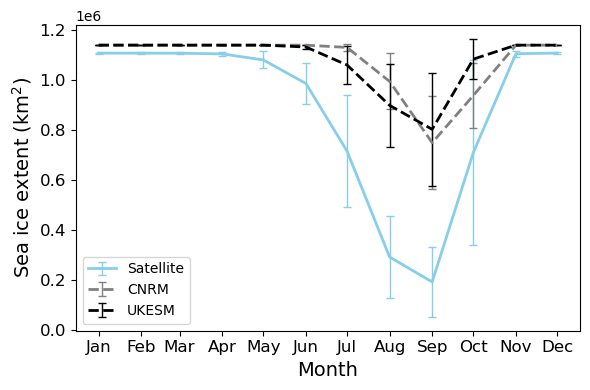

In [53]:
# Creat a figure
fig, ax = plt.subplots(figsize = (6,4))
ax.errorbar([datetime.strptime(str(m).zfill(2), '%m') for m in sat_iceExt_obs.month.values],
            sat_iceExt_obs, yerr = sat_iceExt_obs_sd, capsize = 3, elinewidth = 1, color='skyblue',
            lw = 2, label = 'Satellite', linestyle = '-')
ax.errorbar([datetime.strptime(str(m).zfill(2), '%m') for m in sat_iceExt_obs.month.values],
            cnrm_iceExt_obs/1e6, yerr = cnrm_iceExt_obs_sd/1e6, capsize = 3, elinewidth = 1, color='Grey',
            lw = 2, label = 'CNRM', linestyle = '--')
ax.errorbar([datetime.strptime(str(m).zfill(2), '%m') for m in sat_iceExt_obs.month.values],
            uk_iceExt_obs/1e6, yerr = uk_iceExt_obs_sd/1e6, capsize = 3, elinewidth = 1, color='k',
            lw = 2, label = 'UKESM', linestyle = '--')
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel(r'Sea ice extent (km${^2})$', fontsize=14)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.legend(loc = 'best')
fmt = mdate.DateFormatter('%b')
ax.xaxis.set_major_formatter(fmt)
ax.xaxis.set_major_locator(mdate.MonthLocator())
plt.tight_layout()

Figure 2: Monthly averaged sea ice extent from 2002 to 2014 in CNRM (broken grey line) and UKESM (broken black line)<br>
in comparison to satellite data (solid blue line).

### An evaluation of long term trends

In [143]:
cnrm_si_SS_m = cnrm_si_SS.groupby('time.month')
cnrm_no3_SS_m = cnrm_no3_SS.groupby('time.month')
si_past = cnrm_si_SS_m[9]['siconc'][:-13]
si_pres = cnrm_si_SS_m[9]['siconc'][-13:]
no3_past = cnrm_no3_SS_m[9]['no3'][:-13]
no3_pres = cnrm_no3_SS_m[9]['no3'][-13:]

In [85]:
import Functions as f
%load_ext autoreload
%autoreload 2

Text(0.5, 1.0, 'September 2002-2014')

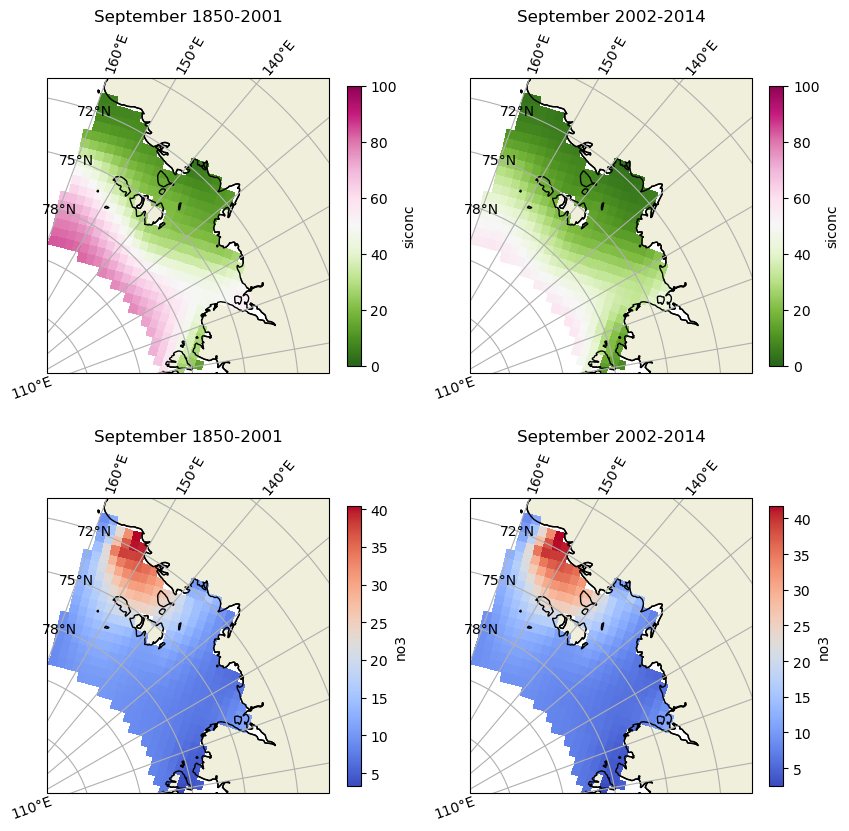

In [154]:
extent = [100,160, 80, 70]
fig = plt.figure(1, figsize=[10,10])

ax = plt.subplot(2, 2, 1, projection=ccrs.NorthPolarStereo())
f.mapfeatures(ax,extent)
ax = si_past.mean(dim = ['time']).plot.pcolormesh(x='lon', y='lat',
    cmap='PiYG_r',
    vmax = 100, vmin = 0,
    transform = ccrs.PlateCarree(),
    cbar_kwargs={ 'orientation':'vertical', 'shrink':.8})
plt.title('September 1850-2001')

ax = plt.subplot(2, 2, 2, projection=ccrs.NorthPolarStereo() )
f.mapfeatures(ax,extent)
ax = si_pres.mean(dim = ['time']).plot.pcolormesh(x='lon', y='lat',
    cmap='PiYG_r',
    vmax = 100, vmin = 0,
    transform = ccrs.PlateCarree(),
    cbar_kwargs={ 'orientation':'vertical', 'shrink':.8})
plt.title('September 2002-2014')

ax = plt.subplot(2, 2, 3, projection=ccrs.NorthPolarStereo() )
f.mapfeatures(ax,extent)
ax = (no3_past*1e3).mean(dim = ['time']).plot.pcolormesh(x='lon', y='lat',
    cmap='coolwarm',
    #vmax =25 , vmin = 0,                                     
    transform = ccrs.PlateCarree(),
    cbar_kwargs={ 'orientation':'vertical', 'shrink':.8})
plt.title('September 1850-2001')

ax = plt.subplot(2, 2, 4, projection=ccrs.NorthPolarStereo() )
f.mapfeatures(ax,extent)
ax = (no3_pres*1e3).mean(dim = ['time']).plot.pcolormesh(x='lon', y='lat',
    cmap='coolwarm',
    #vmax =25 , vmin = 0,
    transform = ccrs.PlateCarree(),
    cbar_kwargs={ 'orientation':'vertical', 'shrink':.8})
plt.title('September 2002-2014')

Figure 3: A comparison of sea ice concentration (top row) and nitrate concentration (bottom row) for the present period of overlap<br>
with observations (2002-2014) (right column) and past period (1850-2001) (left column) for September, the month of minimum sea ice and nutrient availabilty.

### An evaluation of changes in seasonality over time

In [ ]:
cnrm_iceExt
sat_obs = sat_Ext.sel(time = slice('2002','2014'))

### Discusssion and conclusions

### Acknowledgements

### References